# IBS classifier

### library import

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy import interp

%matplotlib inline
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 20)

### data input and log transformation

In [2]:
df_userbase_ori = pd.read_table('../input/FL12FL3study.IBS.userbase.csv', sep=',', encoding="UTF-8").rename({'or_kit_code':'kit_id'}, axis=1).set_index('kit_id')
df_bacteria_ori = pd.read_table('../input/FL12FL3study.IBS.bacteria.csv', sep=',', encoding="UTF-8").rename({'or_kit_code':'kit_id'}, axis=1).set_index('kit_id')

df_userbase = df_userbase_ori

df_bacteria = df_userbase[[]].join(df_bacteria_ori, how='left').copy()
df_bacteria[df_bacteria<0.0001] = 0.00001
df_bacteria = (np.log10(df_bacteria) + 2.5) / 2.5
df_bacteria = df_bacteria.loc[:,df_bacteria.columns[df_bacteria.std() != 0]]

df_userbase.replace('na', np.nan, inplace=True)
df_userbase.IBStype.fillna('HC', inplace=True)
df_userbase.IBS_group.fillna(0, inplace=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  from ipykernel import kernelapp as app


### preparation of IBS classifier

In [3]:
class TrainStandardization:
    def __init__(self, x):
        self.train_ori = train
        self.train_filtered = self.train_ori.loc[:,self.train_ori.columns[self.train_ori.std() != 0]]
        self.ori_mean = self.train_filtered.mean()
        self.ori_std = self.train_filtered.std()
    def transform(self, data):
        return (data - self.ori_mean) / self.ori_std

In [4]:
class LassoLogisticRegressionTransformer(LogisticRegression):
    def __init__(self, C=0.1):
        super().__init__(penalty='l1', solver='liblinear', tol=1e-6, max_iter=100, warm_start=False, C=C)
    def transform(self, X):
        return X.iloc[:,self.coef_[0] != 0]

In [5]:
clf_names = ["RandomForest"]

classifiers = [
    RandomForestClassifier(max_depth=100, n_estimators=100),
]

In [6]:
df_clf = pd.DataFrame([classifiers, clf_names]).transpose()
df_clf.columns = ['classifier', 'clf_name']
df_clf

,classifier,clf_name
0,"RandomForestClassifier(bootstrap=True, class_w...",RandomForest


In [7]:
pipe_clf = []
for (k, v) in df_clf.iterrows():
    pipe_clf.append([('lassologistic', LassoLogisticRegressionTransformer()), (v[1], v[0])])

In [8]:
pipe = []
for i in range(len(pipe_clf)):
    pipe.append(Pipeline(pipe_clf[i]))

In [9]:
param_grid_pipe = [
    {
        'lassologistic__C': [1000,800,600,400,200,100,50,10],
        'RandomForest__max_depth': [100,200]
    }
]

In [10]:
gs_pipe = []
inner_CV = 10
for i in range(len(pipe_clf)):
    gs_pipe.append(GridSearchCV(estimator=pipe[i], param_grid=param_grid_pipe[i], scoring='roc_auc', cv=StratifiedKFold(inner_CV, shuffle=True)))

### 10-fold cross validation with 100 repeats by logistic regression and random forest

In [11]:
%%time

X = df_bacteria.copy()
y = df_userbase.IBS_group.copy()
CV = 10
BS = 100

auc_mean = np.zeros(BS)
auc_std = np.zeros(BS)
acc_mean = np.zeros(BS)
pre_mean = np.zeros(BS)
rec_mean = np.zeros(BS)
AUCscore = []
ACCscore = []
PREscore = []
RECscore = []

for j in range(BS):
    scores = cross_validate(gs_pipe[0], X, y, scoring=['roc_auc','accuracy','precision', 'recall'], cv=StratifiedKFold(CV, shuffle=True))
    auc_mean[j] = scores['test_roc_auc'].mean()
    auc_std[j] = scores['test_roc_auc'].std()
    acc_mean[j] = scores['test_accuracy'].mean()
    pre_mean[j] = scores['test_precision'].mean()
    rec_mean[j] = scores['test_recall'].mean()
    for k in range(CV):
        AUCscore.append(scores['test_roc_auc'][k])
        ACCscore.append(scores['test_accuracy'][k])
        PREscore.append(scores['test_precision'][k])
        RECscore.append(scores['test_recall'][k])
print("AUC(Mean) : " + ('%.6f' % auc_mean.mean()))
print("AUC(SD) : " + ('%.6f' % auc_std.mean()))
print("ACCURACY : " + ('%.6f' % acc_mean.mean()))
print("PRECISION : " + ('%.6f' % pre_mean.mean()))
print("RECALL : " + ('%.6f' % rec_mean.mean()))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ec2-user/anaconda3/

AUC(Mean) : 0.858565
AUC(SD) : 0.145662
ACCURACY : 0.793485
PRECISION : 0.808283
RECALL : 0.965278
CPU times: user 2min 31s, sys: 39.6 ms, total: 2min 31s
Wall time: 2min 31s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### save

In [12]:
import csv
f = open('../output/AUC_HCvsIBS_1000models.csv', 'w')
writer = csv.writer(f, lineterminator='\n')
writer.writerow(AUCscore)
f.close()

f = open('../output/ACCURACY_HCvsIBS_1000models.csv', 'w')
writer = csv.writer(f, lineterminator='\n')
writer.writerow(ACCscore)
f.close()

f = open('../output/PRECISION_HCvsIBS_1000models.csv', 'w')
writer = csv.writer(f, lineterminator='\n')
writer.writerow(PREscore)
f.close()

f = open('../output/RECALL_HCvsIBS_1000models.csv', 'w')
writer = csv.writer(f, lineterminator='\n')
writer.writerow(RECscore)
f.close()

### ROC curve of taxa, SCFA, and "taxa + SCFA"

### data input

In [13]:
df_taxa = df_bacteria.copy()
df_scfa = pd.read_table('../input/scfa.csv', sep=',', encoding="UTF-8").rename({'or_kit_code':'kit_id'}, axis=1).set_index('kit_id')
df_taxa_scfa = pd.read_table('../input/bacteria_sfa.csv', sep=',', encoding="UTF-8").rename({'or_kit_code':'kit_id'}, axis=1).set_index('kit_id')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  app.launch_new_instance()


In [14]:
df_scfa = df_scfa.loc[:,df_scfa.columns[df_scfa.std() != 0]]
df_userbase_scfa = df_scfa[[]].join(df_userbase_ori, how='left')
df_taxa_scfa = df_scfa.join(df_taxa, how='left').copy()

### for taxa

In [15]:
%%time

X = df_taxa.copy()
y = df_userbase.IBS_group.copy()
CV = 10
BS = 100

tprs = []
fprs = []
base_fpr = np.linspace(0, 1, 101)

clf = gs_pipe[0]

for i in range(BS):
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train = X.iloc[train_index,:]
        X_test = X.iloc[test_index,:]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std_tprs = tprs.std(axis=0)
np.save('../output/test_taxa_tprs_mean.npy', mean_tprs)
np.save('../output/test_taxa_tprs_upper.npy', np.minimum(mean_tprs + std_tprs, 1))
np.save('../output/test_taxa_tprs_lower.npy', mean_tprs - std_tprs)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ec2-user/anaconda3/

CPU times: user 2min 31s, sys: 7.98 ms, total: 2min 31s
Wall time: 2min 31s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### for SCFA

In [16]:
%%time

X = df_scfa.copy()
y = df_userbase_scfa.IBS_group.copy()
CV = 10
BS = 100

tprs = []
fprs = []
base_fpr = np.linspace(0, 1, 101)

clf = gs_pipe[0]

for i in range(BS):
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train = X.iloc[train_index,:]
        X_test = X.iloc[test_index,:]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
np.save('../output/test_scfa_tprs_mean.npy', mean_tprs)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ec2-user/anaconda3/

CPU times: user 2min 20s, sys: 28 ms, total: 2min 20s
Wall time: 2min 20s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### for taxa + SCFA

In [17]:
%%time

X = df_taxa_scfa.copy()
y = df_userbase_scfa.IBS_group.copy()
CV = 10
BS = 100

tprs = []
fprs = []
base_fpr = np.linspace(0, 1, 101)

clf = gs_pipe[0]

for i in range(BS):
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for train_index, test_index in skf.split(X, y):
        X_train = X.iloc[train_index,:]
        X_test = X.iloc[test_index,:]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
np.save('../output/test_taxa_scfa_tprs_mean.npy', mean_tprs)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/ec2-user/anaconda3/

CPU times: user 2min 40s, sys: 44 ms, total: 2min 40s
Wall time: 2min 40s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### plot ROC curve

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


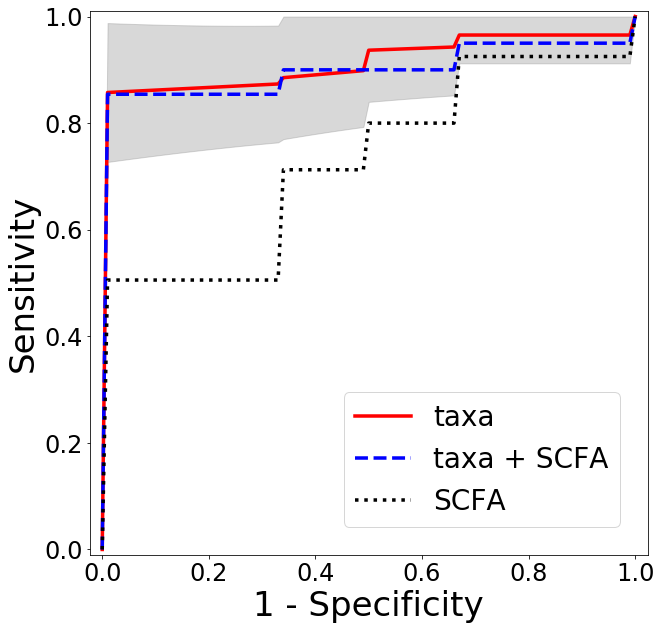

In [18]:
mean_tprs_taxa = np.load('../output/test_taxa_tprs_mean.npy')
mean_tprs_scfa = np.load('../output/test_scfa_tprs_mean.npy')
mean_tprs_taxa_scfa = np.load('../output/test_taxa_scfa_tprs_mean.npy')
tprs_upper = np.load('../output/test_taxa_tprs_upper.npy')
tprs_lower = np.load('../output/test_taxa_tprs_lower.npy')
base_fpr = np.linspace(0, 1, 101)

fig = plt.figure(figsize=(10, 10))
plt.xlabel("xlabel", fontsize=34)
plt.ylabel("ylabel", fontsize=34)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
ax = plt.axes()
plt.plot(base_fpr, mean_tprs_taxa, 'r', linewidth = 3.5, label='taxa')
plt.plot(base_fpr, mean_tprs_taxa_scfa, 'b--', linewidth = 3.5, label='taxa + SCFA')
plt.plot(base_fpr, mean_tprs_scfa, 'k:', linewidth = 3.5, label='SCFA')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('Sensitivity')
plt.xlabel('1 - Specificity')
plt.legend(bbox_to_anchor=(1, 0), loc='lower right', borderaxespad=1, fontsize=28)
plt.axes().set_aspect('equal', 'datalim')
plt.savefig("../output/test_ROC_curve.png", bbox_inches="tight")
plt.show()